In [293]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v2.0/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [294]:
credentials = {}
credentials['name'] = 'keystone'
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['project_id'] = 'd0f42c9472eb4f4ea8d7baf410c86007'
credentials['region'] = 'dallas'
credentials['user_id'] = '3c9982f5ba374e67960af71afbca1ed9'
credentials['password'] = 'y0&pn!Fj93H7sYLd'

In [295]:
set_hadoop_config(credentials)

In [296]:
table = sc.textFile("swift://notebooks.keystone/Leading_Causes_of_Death_by_ZIP_Updated.csv")

In [297]:
print "Total records in the Leading death causes dataset:", table.count()

Total records in the Leading death causes dataset: 320153


In [298]:
dcParse = table.map(lambda line : line.split(","))

In [299]:
dcParse = dcParse.filter(lambda x: x[0] != "Year")
print "The first row in the dataset:", dcParse.count()

The first row in the dataset: 320152


In [300]:
from pyspark.sql import SQLContext, Row
from datetime import datetime

sqlContext = SQLContext(sc)
allData = dcParse.map(lambda p: Row(year=(int(p[0])), zipcode=p[1], cause=p[2],counter=(int(p[3])), latitude=p[4], longitude=p[5]))
allSchema = sqlContext.createDataFrame(allData)
allSchema.registerTempTable("deathCauses")
sqlContext.cacheTable("deathCauses")

In [301]:
#Maximum death in a particular disease
query1 = sqlContext.sql('SELECT cause,sum(counter) as TotalDeaths FROM deathCauses group by cause' ).collect()

In [302]:
#sqlContext.registerDataFrameAsTable(query1, "query1")

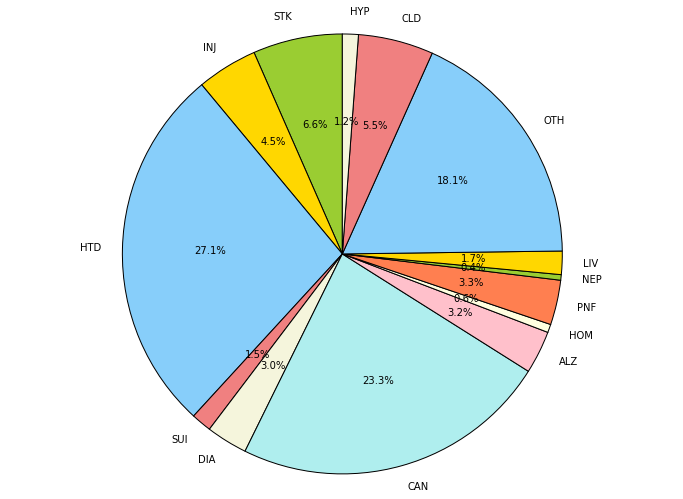

In [303]:
#Death Cause Distribution from 1999-2013
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
 
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )
 
labels = [i[0] for i in query1]
sizes = [int(i[1]) for i in query1]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"] 
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%',  startangle=90) 
plt.axis('equal') 
plt.show()

In [304]:
query1DF = sqlContext.sql('SELECT cause,sum(counter) as TotalDeaths FROM deathCauses group by cause' )

[u'STK', u'INJ', u'HTD', u'SUI', u'DIA', u'CAN', u'ALZ', u'HOM', u'PNF', u'NEP', u'LIV', u'OTH', u'CLD', u'HYP']


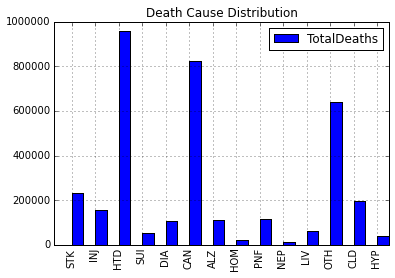

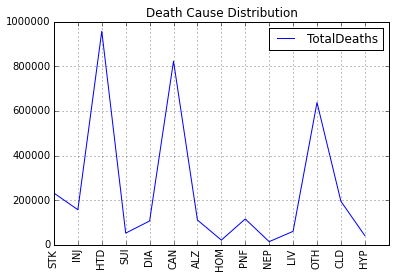

In [305]:
import pandas
from numpy.random import randn
import matplotlib.pyplot as plt

pdf_query1DF=query1DF.toPandas()
labels = [i[0] for i in query1]
print labels
sizes = [int(i[1]) for i in query1]

ax1 = pdf_query1DF.plot(kind='bar', title = "Death Cause Distribution")
ax1.set_xticks(pdf_query1DF.index)
ax1.set_xticklabels(labels, rotation=90)

ax = pdf_query1DF.plot(kind='line',legend ='True' , title = "Death Cause Distribution")
ax.set_xticks(pdf_query1DF.index)
ax.set_xticklabels(labels, rotation=90)

In [479]:
zipBasedDeaths = sqlContext.sql('SELECT zipcode,sum(counter) as TotalDeaths FROM deathCauses group by zipcode  order by TotalDeaths DESC limit 10' ).collect()
for row in zipBasedDeaths:
    print row

Row(zipcode=u'99999', TotalDeaths=24719)
Row(zipcode=u'99998', TotalDeaths=16672)
Row(zipcode=u'95608', TotalDeaths=10673)
Row(zipcode=u'90650', TotalDeaths=9443)
Row(zipcode=u'94558', TotalDeaths=9363)
Row(zipcode=u'94112', TotalDeaths=8994)
Row(zipcode=u'95350', TotalDeaths=8868)
Row(zipcode=u'92543', TotalDeaths=8833)
Row(zipcode=u'92545', TotalDeaths=8687)
Row(zipcode=u'92345', TotalDeaths=8642)


In [480]:
zipBasedDeathsDF = sqlContext.sql('SELECT zipcode,sum(counter) as TotalDeaths FROM deathCauses group by zipcode order by TotalDeaths DESC limit 10' )

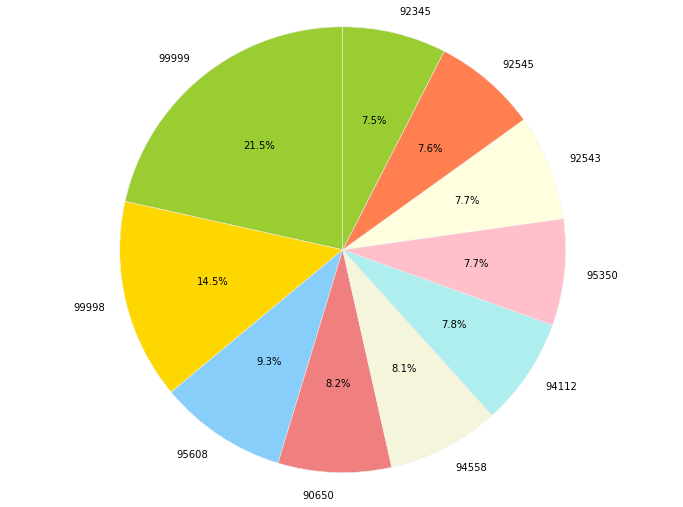

In [481]:
#Zip based Death Cause Distribution from 1999-2013 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
 
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )
 
labels = [i[0] for i in zipBasedDeathsDF.collect()]
sizes = [int(i[1]) for i in zipBasedDeathsDF.collect()]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"] 
plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%',  startangle=90) 
plt.axis('equal') 
plt.show()


[u'99999', u'99998', u'95608', u'90650', u'94558', u'94112', u'95350', u'92543', u'92545', u'92345']


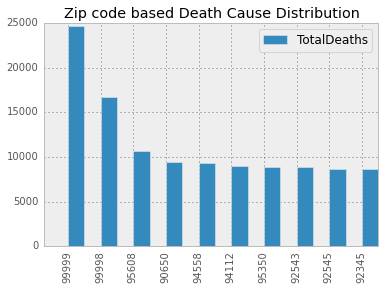

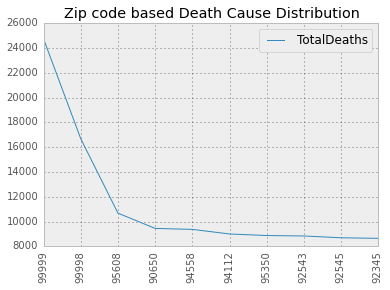

In [482]:
import pandas
from numpy.random import randn
import matplotlib.pyplot as plt

pdf_zipBasedDeathsDF = zipBasedDeathsDF.toPandas()
labels = [i[0] for i in zipBasedDeathsDF.collect()]
print labels
sizes = [int(i[1]) for i in zipBasedDeathsDF.collect()]

ax1 = pdf_zipBasedDeathsDF.plot(kind='bar', title = "Zip code based Death Cause Distribution")
ax1.set_xticks(pdf_zipBasedDeathsDF.index)
ax1.set_xticklabels(labels, rotation=90)

ax = pdf_zipBasedDeathsDF.plot(kind='line',legend ='True' , title = "Zip code based Death Cause Distribution")
ax.set_xticks(pdf_zipBasedDeathsDF.index)
ax.set_xticklabels(labels, rotation=90)

In [483]:
#Death cause distribution each disease in all years
query2 = sqlContext.sql('SELECT year, cause ,sum(counter) as deathcount from deathCauses where year in (1999,2004,2009,2013) group by cause,year order by cause')
#query2 = sqlContext.sql('SELECT cause ,sum(counter) as deathcount from deathCauses where year = 1999 group by cause order by cause')
#for row in query2.collect():
#    print row

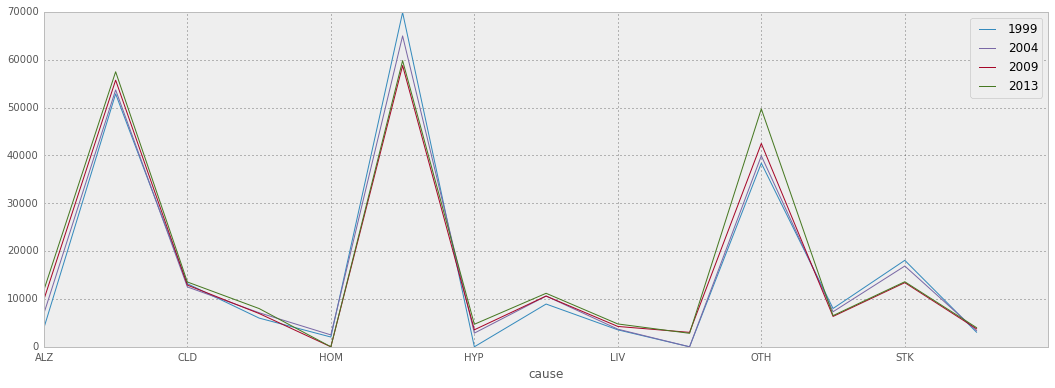

In [437]:
import pandas as pd
from numpy.random import randn
import matplotlib.pyplot as plt

#pd.set_option('display.mpl_style', 'default')
pdf_query2 = query2.toPandas()
#ax1 = pdf_query2.plot(kind='line', title = "Zip code based Death Cause Distribution")

fig, ax = plt.subplots()
labels = []
rows = []
for key, grp in pdf_query2.groupby(['year']):
    ax = grp.plot(ax=ax, kind='line',figsize=(18,6),stacked='True', x='cause', y='deathcount')
    labels.append(key)
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()


In [419]:
query3 = sqlContext.sql('SELECT year, cause ,sum(counter) as deathcount from deathCauses  group by cause,year order by cause')

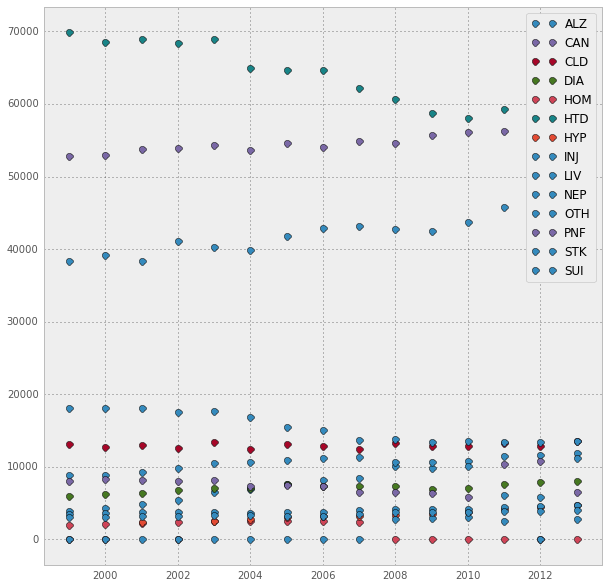

In [440]:
import pandas 
from numpy.random import randn
import matplotlib.pyplot as plt

#pd.set_option('display.mpl_style', 'default')
colors = 'r', 'g', 'b', 'k','m'
pdf_query3 = query3.toPandas()



#ax = pdf_query2.groupby('year')['deathcount'].hist()
#pdf_query2['N'].hist(by=df['Letter'])
#pdf_query2['deathcount'].hist(by=pdf_query2['year'])

groups = pdf_query3.groupby('cause')

# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.year, group.deathcount, marker='o', linestyle='', ms=7, label=name)
ax.legend()

plt.show()


colors = ['#2C543B', '#B1A7B1', '#2C543B','#C41560','#C4D3B7','#462FBC','#C7E6F9','#715C59','#72E975','#A4A876','#FBC1B7','#FBC1B7','#8D225A','#D5A49E']



In [488]:
query4 = sqlContext.sql('SELECT year, zipcode ,sum(counter) as deathcount from deathCauses where zipcode in ("99999", "90650", "94558", "99998","94112", "95350","95608","92545","92345") group by zipcode,year order by zipcode')


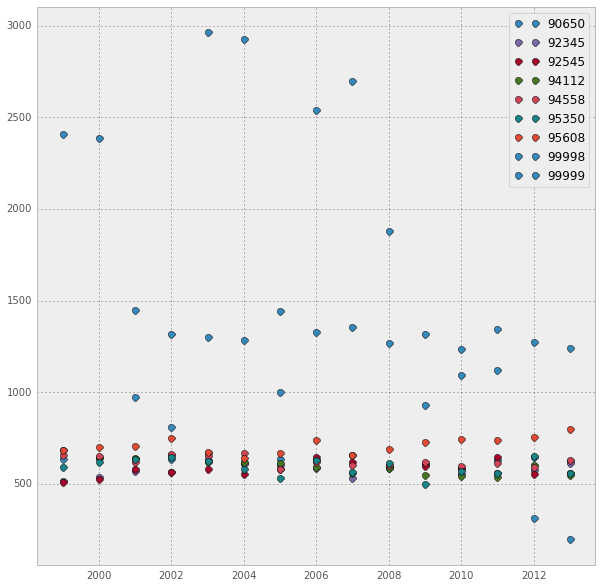

In [489]:
import pandas 
from numpy.random import randn
import matplotlib.pyplot as plt

#pd.set_option('display.mpl_style', 'default')
colors = 'r', 'g', 'b', 'k','m'
pdf_query4 = query4.toPandas()



#ax = pdf_query2.groupby('year')['deathcount'].hist()
#pdf_query2['N'].hist(by=df['Letter'])
#pdf_query2['deathcount'].hist(by=pdf_query2['year'])

groups = pdf_query4.groupby('zipcode')

# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

for name, group in groups:
    ax.plot(group.year, group.deathcount, marker='o', linestyle='', ms=7, label=name)
ax.legend()

plt.show()


colors = ['#2C543B', '#B1A7B1', '#2C543B','#C41560','#C4D3B7','#462FBC','#C7E6F9','#715C59','#72E975','#A4A876','#FBC1B7','#FBC1B7','#8D225A','#D5A49E']
